In [1]:
# ============================================================
# ESPN Fantasy Draft Value Project (Re-ordered, end-to-end)
# - Block-by-block, in a logical pipeline
# - Separates: (A) hygiene + load, (B) league-year filtering,
#              (C) enrichment, (D) optimal lineup valid points,
#              (E) autodraft baseline + scoring, (F) plots
# - Adds: scoring-rule filter using anchor players
# ============================================================

from __future__ import annotations

from pathlib import Path
import re
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# ============================================================
# BLOCK 0 — CONFIG
# ============================================================

RAW_BASE = Path("data/raw/espn")                  # expects subfolders like 2021/, 2022/, ...
OUT_DIR  = Path("data/preprocessed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

YEARS = range(2021, 2025)                         # your current dataset range
RAW_FILES = ["lineup_data.csv", "draft_data.csv", "transaction_data.csv"]

EXPECTED_STARTERS = {"QB":1,"RB":2,"WR":2,"TE":1,"FLEX":1,"K":1,"D/ST":1,"OP":0,"STARTERS":9}
EXPECTED_DRAFT_LENGTH = 160

# "Anchor players" for scoring-rule detection:
# pick players that appear most seasons + are usually drafted/rostered.
# You can tune these later.
ANCHORS_BY_POS = {
    "QB":  ["Josh Allen", "Patrick Mahomes"],
    "RB":  ["Christian McCaffrey", "Derrick Henry"],
    "WR":  ["Justin Jefferson", "Tyreek Hill"],
    "TE":  ["Travis Kelce", "Mark Andrews"],
    "K":   ["Justin Tucker"],
    "D/ST":["Patriots D/ST", "49ers D/ST", "Cowboys D/ST"],  # depends on naming in your data
}
# If anchor names don’t match your dataset strings, add synonyms below.
ANCHOR_SYNONYMS = {
    # "New England Patriots": "Patriots D/ST",
    # "San Francisco 49ers": "49ers D/ST",
}

In [3]:
# ============================================================
# BLOCK 1 — RAW FILE HYGIENE: DROP DUPLICATE ROWS IN EACH YEAR CSV
# ============================================================

def drop_raw_duplicates_in_place(base_dir: Path, years, files) -> None:
    for year in years:
        print(f"\n=== YEAR {year} ===")
        year_dir = base_dir / str(year)

        for fname in files:
            path = year_dir / fname
            if not path.exists():
                print(f"  {fname}: missing")
                continue

            df = pd.read_csv(path)
            before = len(df)
            df2 = df.drop_duplicates()
            after = len(df2)
            dropped = before - after

            if dropped == 0:
                print(f"  {fname}: no duplicates ({before:,} rows)")
            else:
                df2.to_csv(path, index=False)
                print(f"  {fname}: dropped {dropped:,} duplicate rows ({before:,} → {after:,})")


# Run once (safe to re-run)
drop_raw_duplicates_in_place(RAW_BASE, YEARS, RAW_FILES)


=== YEAR 2021 ===
  lineup_data.csv: no duplicates (671,529 rows)
  draft_data.csv: no duplicates (41,452 rows)
  transaction_data.csv: no duplicates (96,580 rows)

=== YEAR 2022 ===
  lineup_data.csv: no duplicates (864,477 rows)
  draft_data.csv: no duplicates (52,586 rows)
  transaction_data.csv: no duplicates (112,206 rows)

=== YEAR 2023 ===
  lineup_data.csv: no duplicates (986,534 rows)
  draft_data.csv: no duplicates (65,593 rows)
  transaction_data.csv: no duplicates (122,249 rows)

=== YEAR 2024 ===
  lineup_data.csv: no duplicates (1,156,301 rows)
  draft_data.csv: no duplicates (81,805 rows)
  transaction_data.csv: no duplicates (143,318 rows)


In [4]:
# ============================================================
# BLOCK 2 — NORMALIZATION HELPERS
# ============================================================

CORE_POS = {"QB", "RB", "WR", "TE", "K", "D/ST", "DST", "DEF"}

def normalize_player_name(name: str) -> str:
    if pd.isna(name):
        return name
    s = str(name).strip()
    s = re.sub(r"\s+", " ", s)
    s = s.replace(" Jr.", "").replace(" Sr.", "")
    # apply anchor synonyms (optional)
    s = ANCHOR_SYNONYMS.get(s, s)
    return s

def normalize_slot(slot: str) -> str:
    s = str(slot).strip().upper()
    if s in {"DST", "DEF", "D/ST"}:
        return "D/ST"
    if s in {"BE", "BENCH"}:
        return "BE"
    if s in {"IR"}:
        return "IR"
    if s in {"RB/WR/TE", "FLEX"}:
        return "FLEX"
    if s in {"OP", "SUPERFLEX", "QB/RB/WR/TE"}:
        return "OP"
    return s

In [5]:
# ============================================================
# BLOCK 3 — LOADERS (multi-season draft + lineups)
# ============================================================

def load_draft(path: Path, year: int) -> pd.DataFrame:
    df = pd.read_csv(path)
    required = ["League_ID","Player","Team","Round","Pick","Overall","Is_Autodrafted","Auto_Draft_Type_ID"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"{path} draft_data is missing columns: {missing}")

    df = df.copy()
    df["Year"] = int(year)
    df["Player_norm"] = df["Player"].map(normalize_player_name)
    df["League_ID"] = df["League_ID"].astype(int)
    df["Year"] = df["Year"].astype(int)
    df["Overall"] = pd.to_numeric(df["Overall"], errors="coerce")
    df["Is_Autodrafted"] = pd.to_numeric(df["Is_Autodrafted"], errors="coerce").fillna(0).astype(int)
    return df

def load_lineups(path: Path, year: int) -> pd.DataFrame:
    df = pd.read_csv(path)
    required = ["League_ID","Week","Team","Player","Slot","Points"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"{path} lineup_data is missing columns: {missing}")

    df = df.copy()
    df["Year"] = int(year)
    df["Player_norm"] = df["Player"].map(normalize_player_name)
    df["League_ID"] = df["League_ID"].astype(int)
    df["Year"] = df["Year"].astype(int)
    df["Week"] = pd.to_numeric(df["Week"], errors="coerce")
    df["Points"] = pd.to_numeric(df["Points"], errors="coerce")
    df["Slot"] = df["Slot"].astype(str).str.strip()
    if "Is_Starter" in df.columns:
        df["Is_Starter"] = pd.to_numeric(df["Is_Starter"], errors="coerce")
    return df

def load_multi_season(raw_base: Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    draft_parts = []
    lineup_parts = []

    for year_dir in sorted([p for p in raw_base.iterdir() if p.is_dir() and p.name.isdigit() and len(p.name) == 4]):
        year = int(year_dir.name)

        dpath = year_dir / "draft_data.csv"
        lpath = year_dir / "lineup_data.csv"

        if dpath.exists():
            draft_parts.append(load_draft(dpath, year))
        else:
            print(f"Skipping {year}: missing {dpath}")

        if lpath.exists():
            lineup_parts.append(load_lineups(lpath, year))
        else:
            print(f"Skipping {year}: missing {lpath}")

    if not draft_parts:
        raise FileNotFoundError(f"No draft_data.csv found under {raw_base}/<YEAR>/draft_data.csv")
    if not lineup_parts:
        raise FileNotFoundError(f"No lineup_data.csv found under {raw_base}/<YEAR>/lineup_data.csv")

    draft_all = pd.concat(draft_parts, ignore_index=True)
    lineups_all = pd.concat(lineup_parts, ignore_index=True)
    return draft_all, lineups_all


draft_raw, lineups_raw = load_multi_season(RAW_BASE)

In [6]:
# ============================================================
# BLOCK 4 — BASIC DRAFT METADATA
# ============================================================

def add_draft_length(draft_df: pd.DataFrame) -> pd.DataFrame:
    out = draft_df.copy()
    out["Draft_Length"] = (
        out.groupby(["League_ID", "Year"], dropna=False)["Overall"]
          .transform("max")
    )
    out["Draft_Length"] = pd.to_numeric(out["Draft_Length"], errors="coerce").fillna(-1).astype(int)
    return out

draft_raw = add_draft_length(draft_raw)

In [7]:
# ============================================================
# BLOCK 5 — FILTER #1: STANDARD STARTER SIGNATURE (league-year)
# ============================================================

def infer_league_starter_signature(lineups: pd.DataFrame) -> pd.DataFrame:
    df = lineups.copy()
    required = {"League_ID","Year","Team","Week","Slot","Is_Starter"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"lineups missing columns for starter signature: {sorted(missing)}")

    df["Slot_norm"] = df["Slot"].map(normalize_slot)
    starters = df[df["Is_Starter"].fillna(0).astype(int) == 1].copy()

    tw = (
        starters.groupby(["League_ID","Year","Team","Week","Slot_norm"])
        .size()
        .reset_index(name="n")
    )

    pivot = (
        tw.pivot_table(
            index=["League_ID","Year","Team","Week"],
            columns="Slot_norm",
            values="n",
            aggfunc="sum",
            fill_value=0,
        )
        .reset_index()
    )

    for col in ["QB","RB","WR","TE","K","D/ST","FLEX","OP"]:
        if col not in pivot.columns:
            pivot[col] = 0

    pivot["Starters_Total"] = pivot[["QB","RB","WR","TE","K","D/ST","FLEX","OP"]].sum(axis=1)

    def mode_int(s: pd.Series) -> int:
        vc = s.value_counts()
        return int(vc.index[0]) if len(vc) else 0

    league_sig = (
        pivot.groupby(["League_ID","Year"], dropna=False)
        .agg(
            QB=("QB", mode_int),
            RB=("RB", mode_int),
            WR=("WR", mode_int),
            TE=("TE", mode_int),
            K=("K", mode_int),
            DST=("D/ST", mode_int),
            FLEX=("FLEX", mode_int),
            OP=("OP", mode_int),
            Starters_Total=("Starters_Total", mode_int),
        )
        .reset_index()
    )

    league_sig["Signature"] = (
        "QB=" + league_sig["QB"].astype(str) +
        ",RB=" + league_sig["RB"].astype(str) +
        ",WR=" + league_sig["WR"].astype(str) +
        ",TE=" + league_sig["TE"].astype(str) +
        ",FLEX=" + league_sig["FLEX"].astype(str) +
        ",K=" + league_sig["K"].astype(str) +
        ",DST=" + league_sig["DST"].astype(str) +
        ",OP=" + league_sig["OP"].astype(str) +
        ",START=" + league_sig["Starters_Total"].astype(str)
    )
    return league_sig

def filter_standard_leagues(
    draft: pd.DataFrame,
    lineups: pd.DataFrame,
    *,
    expected: dict[str, int] | None = None,
    verbose: bool = True
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    if expected is None:
        expected = {"QB":1, "RB":2, "WR":2, "TE":1, "FLEX":1, "K":1, "D/ST":1, "OP":0, "STARTERS":9}

    league_sig = infer_league_starter_signature(lineups)

    keep = (
        (league_sig["QB"] == expected["QB"]) &
        (league_sig["RB"] == expected["RB"]) &
        (league_sig["WR"] == expected["WR"]) &
        (league_sig["TE"] == expected["TE"]) &
        (league_sig["FLEX"] == expected["FLEX"]) &
        (league_sig["K"] == expected["K"]) &
        (league_sig["DST"] == expected["D/ST"]) &
        (league_sig["OP"] == expected["OP"]) &
        (league_sig["Starters_Total"] == expected["STARTERS"])
    )
    league_sig["Keep_Standard"] = keep

    kept = league_sig[league_sig["Keep_Standard"]][["League_ID","Year"]]
    draft_filt  = draft.merge(kept, on=["League_ID","Year"], how="inner")
    lineups_filt = lineups.merge(kept, on=["League_ID","Year"], how="inner")

    if verbose:
        total = len(league_sig)
        k = int(league_sig["Keep_Standard"].sum())
        print(f"[filter_standard_leagues] keeping {k}/{total} league-years ({k/total:.1%})")
        if total - k > 0:
            print("[filter_standard_leagues] top non-standard signatures:")
            print(league_sig.loc[~league_sig["Keep_Standard"], "Signature"].value_counts().head(10))

    return draft_filt, lineups_filt, league_sig


draft_std, lineups_std, league_sig = filter_standard_leagues(
    draft_raw, lineups_raw,
    expected=EXPECTED_STARTERS,
    verbose=True
)

[filter_standard_leagues] keeping 840/1349 league-years (62.3%)
[filter_standard_leagues] top non-standard signatures:
Signature
QB=1,RB=2,WR=2,TE=1,FLEX=2,K=1,DST=1,OP=0,START=10    123
QB=1,RB=2,WR=3,TE=1,FLEX=1,K=1,DST=1,OP=0,START=10     47
QB=1,RB=2,WR=2,TE=1,FLEX=2,K=0,DST=1,OP=0,START=9      41
QB=2,RB=2,WR=2,TE=1,FLEX=1,K=1,DST=1,OP=0,START=10     31
QB=1,RB=2,WR=2,TE=1,FLEX=2,K=1,DST=0,OP=0,START=9      18
QB=1,RB=2,WR=2,TE=1,FLEX=0,K=1,DST=1,OP=0,START=8      17
QB=2,RB=2,WR=2,TE=1,FLEX=2,K=1,DST=1,OP=0,START=11     13
QB=1,RB=2,WR=2,TE=1,FLEX=1,K=1,DST=1,OP=1,START=10     11
QB=1,RB=2,WR=2,TE=1,FLEX=1,K=0,DST=1,OP=1,START=9       9
QB=1,RB=2,WR=2,TE=1,FLEX=1,K=0,DST=1,OP=0,START=8       9
Name: count, dtype: int64


In [8]:
# ============================================================
# BLOCK 6 — FILTER #2: SCORING-RULE FILTER USING ANCHOR PLAYERS (league-year)
# ============================================================

def _season_points_by_league_year(lineups: pd.DataFrame) -> pd.DataFrame:
    df = lineups.copy()
    df["Points"] = pd.to_numeric(df["Points"], errors="coerce")
    return (
        df.groupby(["League_ID","Year","Player_norm"], dropna=False)["Points"]
          .sum(min_count=1)
          .reset_index()
          .rename(columns={"Points":"Season_Total_Points"})
    )

def filter_scoring_rule_outliers(
    draft: pd.DataFrame,
    lineups: pd.DataFrame,
    *,
    anchors_by_pos: dict[str, list[str]] | None = None,
    z_thresh: float = 3.5,
    min_anchors_hit: int = 4,
    verbose: bool = True
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Goal: remove league-years with strange scoring rules.
    Method:
      - compute Season_Total_Points per (League_ID, Year, Player_norm)
      - for each position group, look at anchor player season totals across league-years
      - compute robust z-score via median/MAD per (Year, anchor)
      - mark league-year as outlier if too many anchors are extreme
    Notes:
      - This is intentionally simple + robust.
      - Works even if you don't have explicit scoring settings.
    """
    if anchors_by_pos is None:
        anchors_by_pos = ANCHORS_BY_POS

    # build season totals
    pts = _season_points_by_league_year(lineups)

    # build anchor table
    anchor_rows = []
    for pos, names in anchors_by_pos.items():
        for n in names:
            anchor_rows.append((pos, normalize_player_name(n)))
    anchors = pd.DataFrame(anchor_rows, columns=["AnchorPos","Player_norm"]).drop_duplicates()

    # join to season totals
    a = pts.merge(anchors, on="Player_norm", how="inner")
    if a.empty:
        meta = pd.DataFrame(columns=["League_ID","Year","Anchors_Hit","Anchors_Outlier","Drop"])
        return draft, lineups, meta

    # robust z per (Year, Player_norm)
    def robust_z(s: pd.Series) -> pd.Series:
        x = s.astype(float)
        med = np.nanmedian(x)
        mad = np.nanmedian(np.abs(x - med))
        if mad == 0 or np.isnan(mad):
            return (x - med) * 0.0
        return 0.6745 * (x - med) / mad  # ~ std units for normal

    a["rz"] = a.groupby(["Year","Player_norm"], dropna=False)["Season_Total_Points"].transform(robust_z)
    a["Is_Outlier"] = a["rz"].abs() >= z_thresh

    # league-year summary
    meta = (
        a.groupby(["League_ID","Year"], dropna=False)
         .agg(
            Anchors_Hit=("Player_norm","nunique"),
            AnchorRows=("Player_norm","size"),
            Anchors_Outlier=("Is_Outlier","sum"),
            MaxAbsRZ=("rz", lambda s: float(np.nanmax(np.abs(s.to_numpy()))) if len(s) else np.nan),
         )
         .reset_index()
    )

    # drop if: too many outliers OR not enough anchors observed
    meta["Drop"] = (meta["Anchors_Hit"] < min_anchors_hit) | (meta["Anchors_Outlier"] >= 1)

    kept = meta[~meta["Drop"]][["League_ID","Year"]]
    draft_filt = draft.merge(kept, on=["League_ID","Year"], how="inner")
    lineups_filt = lineups.merge(kept, on=["League_ID","Year"], how="inner")

    if verbose:
        total = meta.shape[0]
        kept_n = kept.shape[0]
        print(f"[filter_scoring_rule_outliers] keeping {kept_n}/{total} league-years ({kept_n/total:.1%})")
        if total - kept_n > 0:
            print("[filter_scoring_rule_outliers] examples of dropped league-years:")
            print(meta[meta["Drop"]].sort_values(["Anchors_Hit","Anchors_Outlier","MaxAbsRZ"], ascending=[True,False,False]).head(10))

    return draft_filt, lineups_filt, meta


draft_filt, lineups_filt, scoring_meta = filter_scoring_rule_outliers(
    draft_std, lineups_std,
    z_thresh=3.5,
    min_anchors_hit=4,
    verbose=True
)

[filter_scoring_rule_outliers] keeping 486/840 league-years (57.9%)
[filter_scoring_rule_outliers] examples of dropped league-years:
     League_ID  Year  Anchors_Hit  AnchorRows  Anchors_Outlier   MaxAbsRZ  \
804    1741809  2024            9           9                6  15.131875   
369    1169860  2024            9           9                6  11.590750   
515    1264240  2024           10          10                7  13.898250   
452    1222001  2024           10          10                3   8.347711   
451    1222001  2023           11          11                9  14.670375   
662    1382708  2024           11          11                8  41.588250   
212    1022020  2024           11          11                8  35.535500   
500    1245727  2024           11          11                6  27.991750   
373    1172559  2024           11          11                6  20.504800   
198    1013919  2024           11          11                6  20.270500   

     Drop  
804  Tr

In [9]:
# ============================================================
# BLOCK 7 — OPTIONAL FILTER #3: DRAFT LENGTH (league-year)
# ============================================================

def filter_draft_length(draft: pd.DataFrame, lineups: pd.DataFrame, *, length: int, verbose: bool = True):
    d = draft.copy()
    if "Draft_Length" not in d.columns:
        d = add_draft_length(d)

    kept = (
        d.groupby(["League_ID","Year"], dropna=False)["Draft_Length"]
         .max()
         .reset_index()
    )
    kept = kept[kept["Draft_Length"] == int(length)][["League_ID","Year"]]

    d2 = d.merge(kept, on=["League_ID","Year"], how="inner")
    l2 = lineups.merge(kept, on=["League_ID","Year"], how="inner")

    if verbose:
        total = d.groupby(["League_ID","Year"]).ngroups
        kept_n = kept.shape[0]
        print(f"[filter_draft_length] keeping {kept_n}/{total} league-years ({kept_n/total:.1%}) with Draft_Length={length}")

    return d2, l2


draft_filt, lineups_filt = filter_draft_length(
    draft_filt, lineups_filt,
    length=EXPECTED_DRAFT_LENGTH,
    verbose=True
)

[filter_draft_length] keeping 345/486 league-years (71.0%) with Draft_Length=160


In [10]:
# ============================================================
# BLOCK 8 — ENRICHMENT: POSITION + SEASON TOTAL POINTS (simple)
# ============================================================

def infer_position_from_slots(lineups: pd.DataFrame) -> pd.DataFrame:
    x = lineups.copy()
    x["Slot_norm"] = x["Slot"].map(normalize_slot)
    x["Is_core_pos"] = x["Slot_norm"].isin({"QB","RB","WR","TE","K","D/ST"})

    counts = (
        x.groupby(["League_ID","Year","Player_norm","Slot_norm","Is_core_pos"], dropna=False)
         .size().reset_index(name="n")
         .sort_values(by=["League_ID","Year","Player_norm","Is_core_pos","n"],
                      ascending=[True,True,True,False,False])
    )

    top = (
        counts.drop_duplicates(subset=["League_ID","Year","Player_norm"])
              .rename(columns={"Slot_norm":"Position"})[["League_ID","Year","Player_norm","Position"]]
    )
    return top

def season_points_from_lineups(lineups: pd.DataFrame) -> pd.DataFrame:
    df = lineups.copy()
    df["Points"] = pd.to_numeric(df["Points"], errors="coerce")
    return (
        df.groupby(["League_ID","Year","Player_norm"], dropna=False)["Points"]
          .sum(min_count=1)
          .reset_index()
          .rename(columns={"Points":"Season_Total_Points"})
    )

def build_draft_enriched(draft: pd.DataFrame, lineups: pd.DataFrame) -> pd.DataFrame:
    d = draft.copy()
    d["Player_norm"] = d["Player_norm"].map(normalize_player_name)

    pos = infer_position_from_slots(lineups)
    pts = season_points_from_lineups(lineups)

    out = d.merge(pos, on=["League_ID","Year","Player_norm"], how="left")
    out = out.merge(pts, on=["League_ID","Year","Player_norm"], how="left")

    out["Season_Total_Points"] = pd.to_numeric(out["Season_Total_Points"], errors="coerce").fillna(0.0)

    # keep a clean set of columns
    cols = [
        "League_ID","Year","Team","Player",
        "Round","Pick","Overall",
        "Draft_Length",
        "Position","Season_Total_Points",
        "Is_Autodrafted","Auto_Draft_Type_ID",
        "Player_norm",
    ]
    for c in cols:
        if c not in out.columns:
            out[c] = np.nan
    return out[cols].copy()


draft_enriched = build_draft_enriched(draft_filt, lineups_filt)
draft_enriched_path = OUT_DIR / "draft_enriched_filtered.csv"
draft_enriched.to_csv(draft_enriched_path, index=False)
print(f"[saved] {draft_enriched_path} ({len(draft_enriched):,} rows)")



[saved] data\preprocessed\draft_enriched_filtered.csv (55,200 rows)


In [11]:
# ============================================================
# BLOCK 9 — OPTIMAL STARTABLE POINTS (“VALID POINTS”) PIPELINE
#   (points that could count if lineup was always optimized)
# ============================================================

def _normalize_slot_defense(slot: str) -> str:
    slot = str(slot).strip()
    return {"DST": "D/ST", "DEF": "D/ST"}.get(slot, slot)

def infer_player_position_by_core_starts(lineups: pd.DataFrame) -> pd.DataFrame:
    CORE = {"QB", "RB", "WR", "TE", "K", "D/ST"}
    df = lineups.copy()
    df["Slot"] = df["Slot"].map(_normalize_slot_defense)

    if "Year" not in df.columns:
        raise ValueError("lineups must include a 'Year' column for multi-season processing.")

    core_rows = df[df["Slot"].isin(CORE)].copy()
    if core_rows.empty:
        raise ValueError("No core slots found in lineup_data Slot column (QB/RB/WR/TE/K/DST).")

    pos = (
        core_rows.groupby(["League_ID", "Year", "Team", "Player_norm"])["Slot"]
        .agg(lambda s: s.value_counts().index[0])
        .reset_index()
        .rename(columns={"Slot": "Position"})
    )
    return pos

def build_player_week_points(lineups: pd.DataFrame) -> pd.DataFrame:
    df = lineups.copy()
    df["Slot"] = df["Slot"].map(_normalize_slot_defense)
    df["Points"] = pd.to_numeric(df["Points"], errors="coerce").fillna(0.0)

    if "Year" not in df.columns:
        raise ValueError("lineups must include a 'Year' column for multi-season processing.")

    pw = (
        df.groupby(["League_ID", "Year", "Team", "Week", "Player_norm"], dropna=False)["Points"]
        .max()
        .reset_index()
        .rename(columns={"Points": "WeekPoints"})
    )
    return pw

def choose_optimal_lineup_for_group(
    g: pd.DataFrame,
    slot_counts: dict[str,int],
    flex_eligible: set[str]
) -> pd.DataFrame:
    g = g.copy()
    g["SelectedOptimal"] = False
    used = set()

    def select_top(pos, n):
        nonlocal used
        if n <= 0:
            return []
        cand = g[(g["Position"] == pos) & (~g["Player_norm"].isin(used))].sort_values("WeekPoints", ascending=False)
        chosen = cand.head(n)["Player_norm"].tolist()
        used.update(chosen)
        return chosen

    def select_flex(n):
        nonlocal used
        if n <= 0:
            return []
        cand = g[(g["Position"].isin(flex_eligible)) & (~g["Player_norm"].isin(used))].sort_values("WeekPoints", ascending=False)
        chosen = cand.head(n)["Player_norm"].tolist()
        used.update(chosen)
        return chosen

    selected = []
    for pos in ["QB", "RB", "WR", "TE", "K", "D/ST"]:
        selected += select_top(pos, slot_counts.get(pos, 0))
    selected += select_flex(slot_counts.get("FLEX", 0))

    g.loc[g["Player_norm"].isin(selected), "SelectedOptimal"] = True
    return g

def compute_optimal_startable_points(
    lineups: pd.DataFrame,
    *,
    slot_counts: dict[str,int] | None = None,
    flex_eligible: set[str] | None = None,
    status_every: int = 250
) -> pd.DataFrame:
    if slot_counts is None:
        slot_counts = {"QB":1, "RB":2, "WR":2, "TE":1, "FLEX":1, "K":1, "D/ST":1}
    if flex_eligible is None:
        flex_eligible = {"RB","WR","TE"}

    t_all = time.time()
    print("[compute_optimal_startable_points] start", flush=True)

    df = lineups.copy()
    df["Player_norm"] = df["Player_norm"] if "Player_norm" in df.columns else df["Player"].astype(str).str.strip()
    df["Slot"] = df["Slot"].map(_normalize_slot_defense)

    if "Year" not in df.columns:
        raise ValueError("lineups must include a 'Year' column for multi-season processing.")

    print(f"[compute_optimal_startable_points] rows: {len(df):,}", flush=True)

    pos = infer_player_position_by_core_starts(df)
    pw = build_player_week_points(df)

    pw = pw.merge(pos, on=["League_ID","Year","Team","Player_norm"], how="left")
    pw["Position"] = pw["Position"].fillna("UNKNOWN")

    gb = pw.groupby(["League_ID","Year","Team","Week"], sort=False)
    n_groups = gb.ngroups
    print(f"[compute_optimal_startable_points] optimizing {n_groups:,} team-weeks...", flush=True)

    t0 = time.time()
    selected_parts = []
    for i, (_, g) in enumerate(gb, start=1):
        if i % status_every == 0 or i == 1 or i == n_groups:
            elapsed = time.time() - t0
            rate = i / elapsed if elapsed > 0 else float("inf")
            print(f"  - progress: {i:,}/{n_groups:,} groups ({rate:.1f} groups/s)", flush=True)
        selected_parts.append(choose_optimal_lineup_for_group(g, slot_counts, flex_eligible))

    selected = pd.concat(selected_parts, ignore_index=True)
    print(f"[compute_optimal_startable_points] done in {time.time()-t_all:.2f}s", flush=True)
    return selected

def add_season_total_points_valid(
    draft_enriched: pd.DataFrame,
    optimal_selected: pd.DataFrame
) -> pd.DataFrame:
    for col in ["Year", "League_ID", "Team", "Player_norm"]:
        if col not in draft_enriched.columns:
            raise ValueError(f"draft_enriched missing required column '{col}' for multi-season merge.")
    if "Year" not in optimal_selected.columns:
        raise ValueError("optimal_selected missing 'Year' column.")

    valid = (
        optimal_selected[optimal_selected["SelectedOptimal"]]
        .groupby(["League_ID","Year","Team","Player_norm"], dropna=False)["WeekPoints"]
        .sum()
        .reset_index()
        .rename(columns={"WeekPoints":"Season_Total_Points_Valid"})
    )

    out = draft_enriched.merge(valid, on=["League_ID","Year","Team","Player_norm"], how="left")
    out["Season_Total_Points_Valid"] = pd.to_numeric(out["Season_Total_Points_Valid"], errors="coerce").fillna(0.0)
    return out


optimal_selected = compute_optimal_startable_points(
    lineups_filt,
    slot_counts={"QB":1,"RB":2,"WR":2,"TE":1,"FLEX":1,"K":1,"D/ST":1},
    flex_eligible={"RB","WR","TE"},
    status_every=250
)

draft_with_valid = add_season_total_points_valid(draft_enriched, optimal_selected)
draft_with_valid_path = OUT_DIR / "draft_with_valid_points_filtered.csv"
draft_with_valid.to_csv(draft_with_valid_path, index=False)
print(f"[saved] {draft_with_valid_path} ({len(draft_with_valid):,} rows)")


[compute_optimal_startable_points] start
[compute_optimal_startable_points] rows: 922,740
[compute_optimal_startable_points] optimizing 56,819 team-weeks...
  - progress: 1/56,819 groups (4.1 groups/s)
  - progress: 250/56,819 groups (144.5 groups/s)
  - progress: 500/56,819 groups (156.8 groups/s)
  - progress: 750/56,819 groups (158.9 groups/s)
  - progress: 1,000/56,819 groups (161.6 groups/s)
  - progress: 1,250/56,819 groups (159.5 groups/s)
  - progress: 1,500/56,819 groups (158.1 groups/s)
  - progress: 1,750/56,819 groups (157.6 groups/s)
  - progress: 2,000/56,819 groups (157.0 groups/s)
  - progress: 2,250/56,819 groups (158.6 groups/s)
  - progress: 2,500/56,819 groups (159.5 groups/s)
  - progress: 2,750/56,819 groups (160.6 groups/s)
  - progress: 3,000/56,819 groups (161.5 groups/s)
  - progress: 3,250/56,819 groups (161.5 groups/s)
  - progress: 3,500/56,819 groups (162.3 groups/s)
  - progress: 3,750/56,819 groups (162.8 groups/s)
  - progress: 4,000/56,819 groups (163.

In [12]:
# ============================================================
# BLOCK 10 — FULLY AUTODRAFTED TEAMS + SANITY CHECK (1.01 variety)
# ============================================================

def identify_fully_autodrafted_teams(
    draft_df: pd.DataFrame,
    *,
    sanity_check_pick1: bool = True,
    verbose: bool = True
) -> pd.DataFrame:
    required = ["League_ID", "Year", "Team", "Is_Autodrafted"]
    missing = [c for c in required if c not in draft_df.columns]
    if missing:
        raise ValueError(f"draft_df missing columns: {missing}")

    result = (
        draft_df
        .groupby(["League_ID", "Year", "Team"], dropna=False)
        .agg(
            Total_Picks=("Is_Autodrafted", "size"),
            Autodrafted_Picks=("Is_Autodrafted", "sum")
        )
        .reset_index()
    )
    result["Is_Fully_Autodrafted"] = (result["Total_Picks"] == result["Autodrafted_Picks"])

    if sanity_check_pick1:
        for c in ["Overall", "Player_norm"]:
            if c not in draft_df.columns:
                raise ValueError(f"Sanity check requires column '{c}'")

        df_auto = draft_df.merge(
            result[["League_ID", "Year", "Team", "Is_Fully_Autodrafted"]],
            on=["League_ID", "Year", "Team"],
            how="left"
        )

        pick1 = df_auto[(df_auto["Is_Fully_Autodrafted"]) & (df_auto["Overall"] == 1)]
        if verbose:
            print("\n[Sanity Check] Fully-Autodrafted 1.01 Picks")
            if pick1.empty:
                print("  none found")
            else:
                summary = (pick1.groupby("Year")["Player_norm"]
                           .agg(Unique_1OA="nunique", Total_1OA="count")
                           .reset_index())
                print(summary.to_string(index=False))
                print(f"\nAcross all years:\n  Total 1.01 picks = {len(pick1)}\n  Unique players  = {pick1['Player_norm'].nunique()}")

    return result


fully_auto = identify_fully_autodrafted_teams(draft_with_valid, sanity_check_pick1=True, verbose=True)




[Sanity Check] Fully-Autodrafted 1.01 Picks
 Year  Unique_1OA  Total_1OA
 2021           2          7
 2022           1          8
 2023           1          7
 2024           2          9

Across all years:
  Total 1.01 picks = 31
  Unique players  = 5


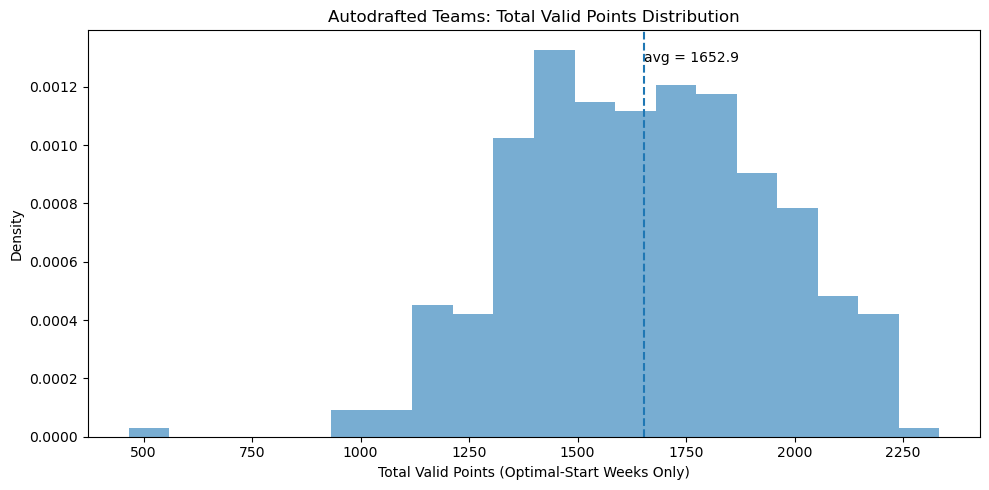

Average Total Valid Points: 1652.89


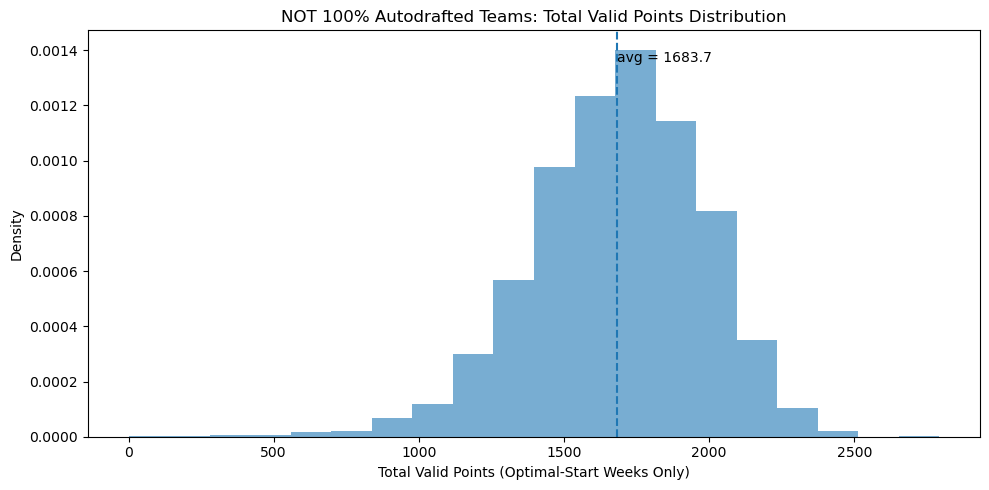

Average Total Valid Points: 1683.69


In [13]:
# ============================================================
# BLOCK 11 — TEAM TOTAL VALID POINTS DISTRIBUTIONS
# ============================================================

def team_total_valid_points(draft_with_valid: pd.DataFrame, *, fully_autodraft_only: bool | None = None) -> pd.DataFrame:
    required = ["League_ID", "Year", "Team", "Is_Autodrafted", "Season_Total_Points_Valid"]
    missing = [c for c in required if c not in draft_with_valid.columns]
    if missing:
        raise ValueError(f"draft_with_valid missing columns: {missing}")

    df = draft_with_valid.copy()

    team_auto = (
        df.groupby(["League_ID", "Year", "Team"], dropna=False)["Is_Autodrafted"]
          .agg(Total_Picks="size", Autodrafted_Picks="sum")
          .reset_index()
    )
    team_auto["Is_Fully_Autodrafted"] = team_auto["Total_Picks"].eq(team_auto["Autodrafted_Picks"])
    df = df.merge(team_auto[["League_ID", "Year", "Team", "Is_Fully_Autodrafted"]],
                  on=["League_ID", "Year", "Team"], how="left")

    if fully_autodraft_only is True:
        df = df[df["Is_Fully_Autodrafted"]].copy()
    elif fully_autodraft_only is False:
        df = df[~df["Is_Fully_Autodrafted"]].copy()

    team_totals = (
        df.groupby(["League_ID", "Year", "Team"], dropna=False)["Season_Total_Points_Valid"]
          .sum()
          .reset_index()
          .rename(columns={"Season_Total_Points_Valid": "Total_Valid_Points"})
          .sort_values("Total_Valid_Points", ascending=False)
    )
    if team_totals.empty:
        raise ValueError("No teams found after filtering.")
    return team_totals

def plot_total_valid_points_dist(team_totals: pd.DataFrame, *, bins: int = 20, title: str = "") -> None:
    x = team_totals["Total_Valid_Points"].astype(float).to_numpy()
    avg = float(np.mean(x))
    plt.figure(figsize=(10, 5))
    plt.hist(x, bins=bins, density=True, alpha=0.6)
    plt.axvline(avg, linestyle="--")
    plt.xlabel("Total Valid Points (Optimal-Start Weeks Only)")
    plt.ylabel("Density")
    plt.title(title or f"Total Valid Points Distribution (n={len(x)})")
    ymin, ymax = plt.ylim()
    plt.text(avg, ymax * 0.95, f"avg = {avg:.1f}", va="top")
    plt.tight_layout()
    plt.show()
    print(f"Average Total Valid Points: {avg:.2f}")

team_totals_auto = team_total_valid_points(draft_with_valid, fully_autodraft_only=True)
plot_total_valid_points_dist(team_totals_auto, bins=20, title="Autodrafted Teams: Total Valid Points Distribution")

team_totals_non = team_total_valid_points(draft_with_valid, fully_autodraft_only=False)
plot_total_valid_points_dist(team_totals_non, bins=20, title="NOT 100% Autodrafted Teams: Total Valid Points Distribution")



In [19]:
# ============================================================
# BLOCK 12 — EXPECTED VALID POINTS BY PICK (autodraft baseline)
# ============================================================

def expected_valid_points_by_pick_autodraft_distribution(draft_with_valid: pd.DataFrame) -> pd.DataFrame:
    required = ["League_ID","Year","Team","Overall","Is_Autodrafted","Season_Total_Points_Valid","Player_norm"]
    missing = [c for c in required if c not in draft_with_valid.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")

    df = draft_with_valid.copy()

    team_auto = (
        df.groupby(["League_ID","Year","Team"], dropna=False)["Is_Autodrafted"]
          .agg(Total_Picks="size", Auto_Picks="sum")
          .reset_index()
    )
    team_auto["Is_Fully_Autodrafted"] = team_auto["Total_Picks"].eq(team_auto["Auto_Picks"])

    df = df.merge(team_auto[["League_ID","Year","Team","Is_Fully_Autodrafted"]],
                  on=["League_ID","Year","Team"], how="left")
    df = df[df["Is_Fully_Autodrafted"]].copy()

    dist = (
        df.groupby("Overall", dropna=False)
        .agg(
            Mean=("Season_Total_Points_Valid", "mean"),
            Std=("Season_Total_Points_Valid", "std"),
            N_Picks=("Season_Total_Points_Valid", "count"),
            Unique_Players=("Player_norm", "nunique"),
            P10=("Season_Total_Points_Valid", lambda s: s.quantile(0.10)),
            P25=("Season_Total_Points_Valid", lambda s: s.quantile(0.25)),
            P50=("Season_Total_Points_Valid", lambda s: s.quantile(0.50)),
            P75=("Season_Total_Points_Valid", lambda s: s.quantile(0.75)),
            P90=("Season_Total_Points_Valid", lambda s: s.quantile(0.90)),
        )
        .reset_index()
        .sort_values("Overall")
    )
    return dist

In [20]:
# ============================================================
# BLOCK 13 — DENOISED EXPECTED CURVE (optional)
# ============================================================

def expected_valid_points_by_pick_from_autodraft_pooled_denoised(
    draft_with_valid: pd.DataFrame,
    *,
    estimator: str = "trimmed_mean",   # "mean" | "median" | "trimmed_mean" | "winsor_mean"
    trim: float = 0.10,
    smooth_window: int = 5
) -> pd.DataFrame:
    required = ["League_ID","Year","Team","Overall","Is_Autodrafted","Season_Total_Points_Valid"]
    missing = [c for c in required if c not in draft_with_valid.columns]
    if missing:
        raise ValueError(f"draft_with_valid missing columns: {missing}")

    df = draft_with_valid.copy()
    df["Overall"] = pd.to_numeric(df["Overall"], errors="coerce").astype(int)
    df["Is_Autodrafted"] = pd.to_numeric(df["Is_Autodrafted"], errors="coerce").fillna(0).astype(int)
    df["Season_Total_Points_Valid"] = pd.to_numeric(df["Season_Total_Points_Valid"], errors="coerce")

    team_auto = (
        df.groupby(["League_ID","Year","Team"], dropna=False)["Is_Autodrafted"]
          .agg(Total_Picks="size", Autodrafted_Picks="sum")
          .reset_index()
    )
    team_auto["Is_Fully_Autodrafted"] = team_auto["Total_Picks"].eq(team_auto["Autodrafted_Picks"])
    df = df.merge(team_auto[["League_ID","Year","Team","Is_Fully_Autodrafted"]],
                  on=["League_ID","Year","Team"], how="left")

    df_auto = df[df["Is_Fully_Autodrafted"]].copy()
    if df_auto.empty:
        raise ValueError("No fully-autodrafted teams found.")

    if estimator == "mean":
        agg_func = "mean"
    elif estimator == "median":
        agg_func = lambda s: float(np.nanmedian(s.to_numpy()))
    elif estimator == "trimmed_mean":
        from scipy.stats import trim_mean
        agg_func = lambda s: float(trim_mean(s.dropna().to_numpy(), proportiontocut=trim))
    elif estimator == "winsor_mean":
        from scipy.stats.mstats import winsorize
        agg_func = lambda s: float(np.mean(winsorize(s.dropna().to_numpy(), limits=trim)))
    else:
        raise ValueError("estimator must be one of: mean, median, trimmed_mean, winsor_mean")

    pooled = (
        df_auto.groupby("Overall", dropna=False)["Season_Total_Points_Valid"]
              .agg(Expected_Valid_Points=agg_func, Std_Valid_Points="std", N="count")
              .reset_index()
              .sort_values("Overall")
    )

    if smooth_window and smooth_window > 1:
        pooled["Expected_Smoothed"] = (
            pooled["Expected_Valid_Points"].rolling(window=smooth_window, center=True, min_periods=1).mean()
        )
    else:
        pooled["Expected_Smoothed"] = pooled["Expected_Valid_Points"]

    return pooled

In [24]:
# ============================================================
# BLOCK 14B — Polynomial baseline (very smooth macro trend)
# ============================================================

import numpy as np
import pandas as pd

def fit_polynomial_baseline(
    expected_pooled: pd.DataFrame,
    *,
    x_col: str = "Overall",
    y_col: str = "Expected_Valid_Points",   # or "Expected_Smoothed"
    w_col: str = "N",
    degree: int = 4,
) -> pd.DataFrame:
    """
    Fits weighted polynomial regression y ~ poly(x) to pooled expected curve.

    Returns expected_pooled with added columns:
      Poly_Expected, Poly_Degree
    """
    df = expected_pooled.copy()

    # clean numeric
    x = pd.to_numeric(df[x_col], errors="coerce").to_numpy(dtype=float)
    y = pd.to_numeric(df[y_col], errors="coerce").to_numpy(dtype=float)

    if w_col in df.columns:
        w = pd.to_numeric(df[w_col], errors="coerce").fillna(1.0).to_numpy(dtype=float)
    else:
        w = np.ones_like(x)

    m = np.isfinite(x) & np.isfinite(y) & np.isfinite(w) & (w > 0)
    x, y, w = x[m], y[m], w[m]

    if len(x) < degree + 2:
        raise ValueError(f"Not enough points to fit degree={degree} polynomial.")

    # weighted poly fit
    coeff = np.polyfit(x, y, deg=degree, w=w)
    p = np.poly1d(coeff)

    df["Poly_Expected"] = p(pd.to_numeric(df[x_col], errors="coerce").to_numpy(dtype=float))
    df["Poly_Degree"] = degree
    return df



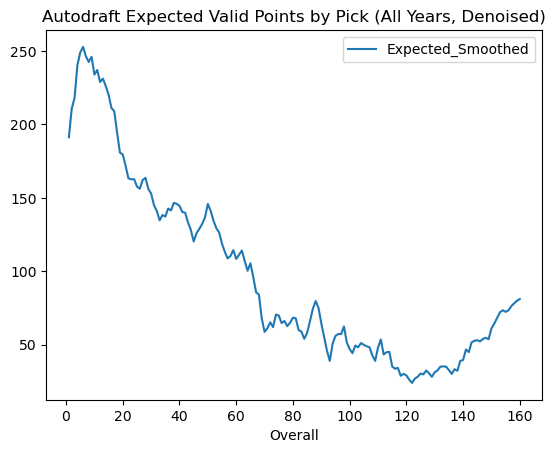

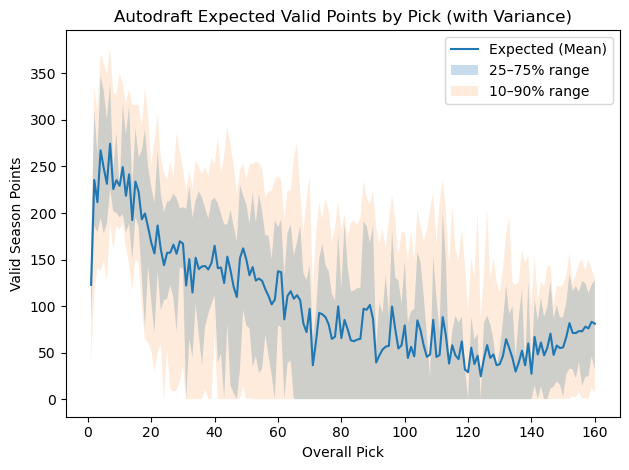

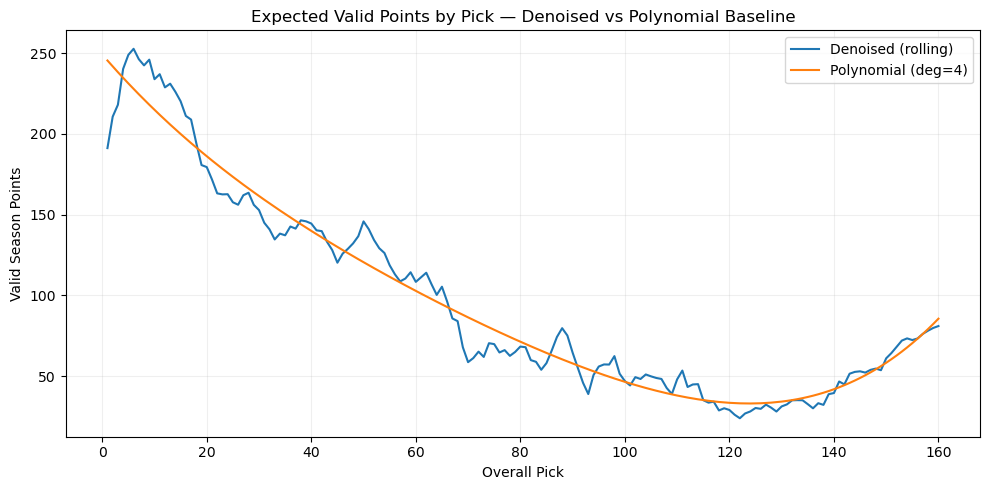

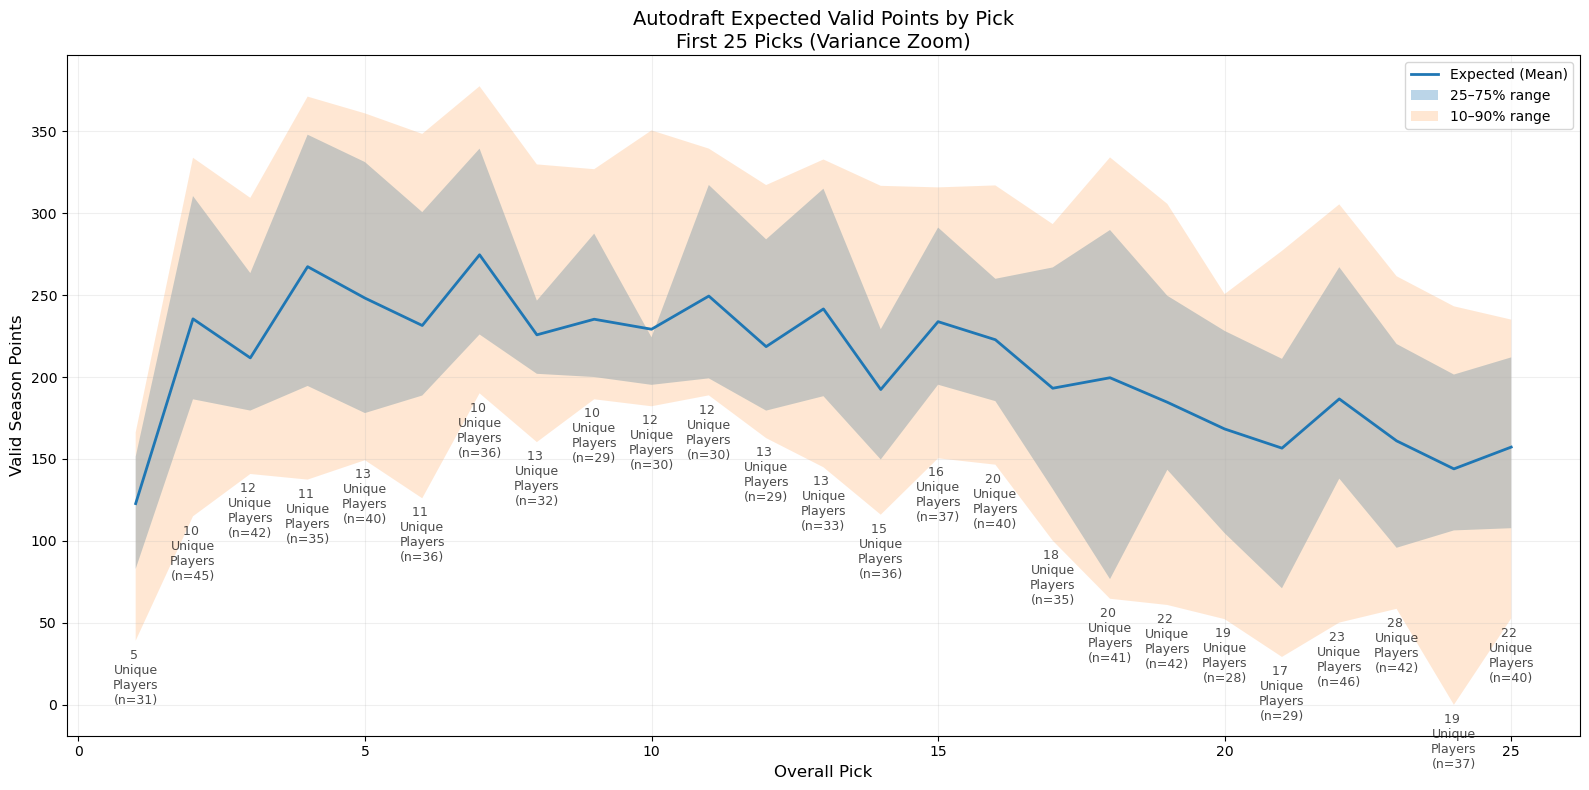

   Overall  Expected_Valid_Points  Expected_Smoothed   N
0        1             121.324000         191.230448  31
1        2             242.796757         210.668526  45
2        3             209.570588         218.078446  42
3        4             268.982759         240.280446  35
4        5             247.718125         248.978428  40
5        6             232.334000         252.720310  36
6        7             286.286667         246.290478  36
7        8             228.280000         242.456353  32
8        9             236.833600         245.994720  29
9       10             228.547500         233.902507  30
     Overall  Expected_Valid_Points  Expected_Smoothed   N
150      151              64.541667          64.324986  30
151      152              81.478261          68.214986  27
152      153              70.875000          72.056917  34
153      154              70.700000          73.413289  35
154      155              72.689655          72.390051  35
155      156       

In [25]:
# ============================================================
# BLOCK 15 — PLOTS (variance band, zoom, denoised curve)
# ============================================================

# 15A: Denoised pooled curve
expected_by_pick_pooled = expected_valid_points_by_pick_from_autodraft_pooled_denoised(
    draft_with_valid,
    estimator="trimmed_mean",
    trim=0.10,
    smooth_window=5
)
expected_by_pick_pooled.plot(x="Overall", y="Expected_Smoothed",
                             title="Autodraft Expected Valid Points by Pick (All Years, Denoised)")
plt.show()

# 15B: Distribution bands (P10–P90, P25–P75)
dist = expected_valid_points_by_pick_autodraft_distribution(draft_with_valid)

plt.plot(dist["Overall"], dist["Mean"], label="Expected (Mean)")
plt.fill_between(dist["Overall"], dist["P25"], dist["P75"], alpha=0.25, label="25–75% range")
plt.fill_between(dist["Overall"], dist["P10"], dist["P90"], alpha=0.15, label="10–90% range")
plt.xlabel("Overall Pick")
plt.ylabel("Valid Season Points")
plt.title("Autodraft Expected Valid Points by Pick (with Variance)")
plt.legend()
plt.tight_layout()

# Smooth Poly Curve
# Choose what you want to fit to:
# - fit to Expected_Smoothed for maximum noise resistance
# - OR fit to Expected_Valid_Points (trimmed mean, no rolling)
expected_by_pick_poly = fit_polynomial_baseline(
    expected_by_pick_pooled,
    y_col="Expected_Smoothed",
    w_col="N",
    degree=4
)
plt.figure(figsize=(10,5))
plt.plot(expected_by_pick_poly["Overall"], expected_by_pick_poly["Expected_Smoothed"], label="Denoised (rolling)")
plt.plot(expected_by_pick_poly["Overall"], expected_by_pick_poly["Poly_Expected"], label=f"Polynomial (deg={int(expected_by_pick_poly['Poly_Degree'].iloc[0])})")
plt.xlabel("Overall Pick"); plt.ylabel("Valid Season Points")
plt.title("Expected Valid Points by Pick — Denoised vs Polynomial Baseline")
plt.grid(alpha=0.2); plt.legend(); plt.tight_layout(); plt.show()

plt.show()

# 15C: Zoom first 25 picks, annotate N (unique players + total picks)
dist_20 = dist[dist["Overall"] <= 25].copy()
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(dist_20["Overall"], dist_20["Mean"], label="Expected (Mean)", linewidth=2)
ax.fill_between(dist_20["Overall"], dist_20["P25"], dist_20["P75"], alpha=0.30, label="25–75% range")
ax.fill_between(dist_20["Overall"], dist_20["P10"], dist_20["P90"], alpha=0.18, label="10–90% range")
ax.set_xlabel("Overall Pick", fontsize=12)
ax.set_ylabel("Valid Season Points", fontsize=12)
ax.set_title("Autodraft Expected Valid Points by Pick\nFirst 25 Picks (Variance Zoom)", fontsize=14)

for _, r in dist_20.iterrows():
    ax.text(
        r["Overall"], r["P10"] - 5,
        f"{int(r['Unique_Players'])} \nUnique\nPlayers\n(n={int(r['N_Picks'])})",
        ha="center", va="top", fontsize=9, alpha=0.7
    )

ax.legend()
ax.grid(alpha=0.2)
fig.tight_layout()
plt.show()

print(expected_by_pick_pooled[["Overall","Expected_Valid_Points","Expected_Smoothed","N"]].head(10))
print(expected_by_pick_pooled[["Overall","Expected_Valid_Points","Expected_Smoothed","N"]].tail(10))

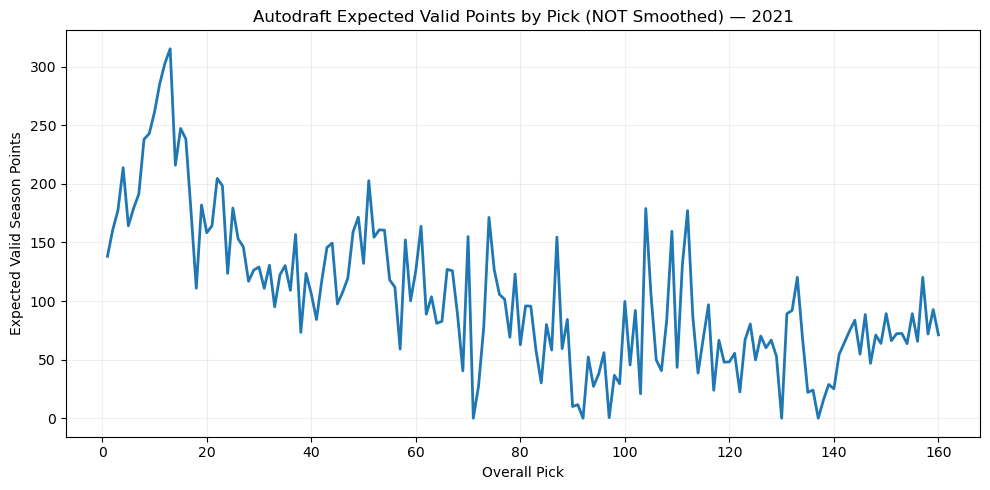

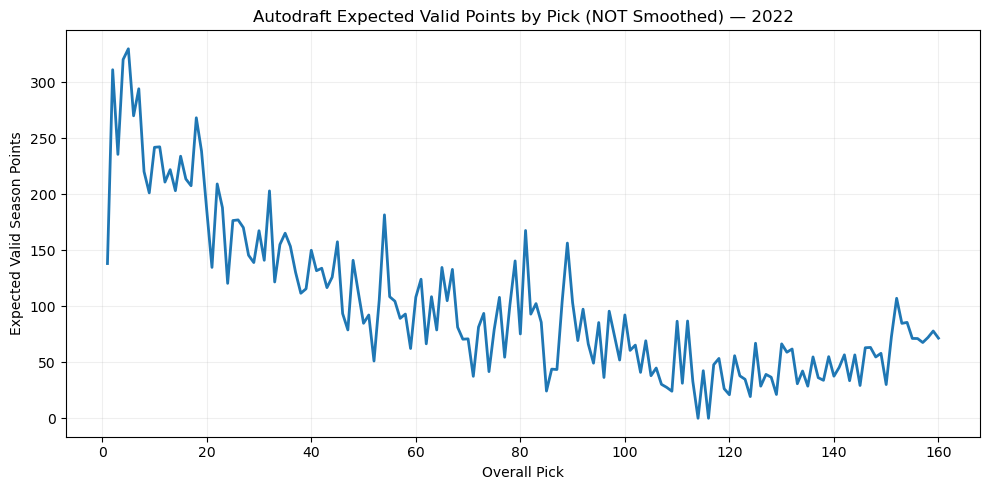

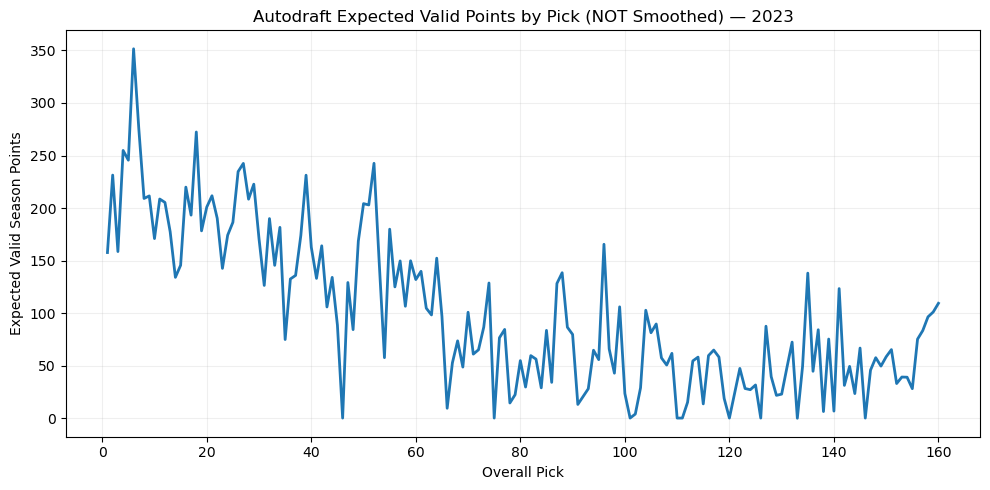

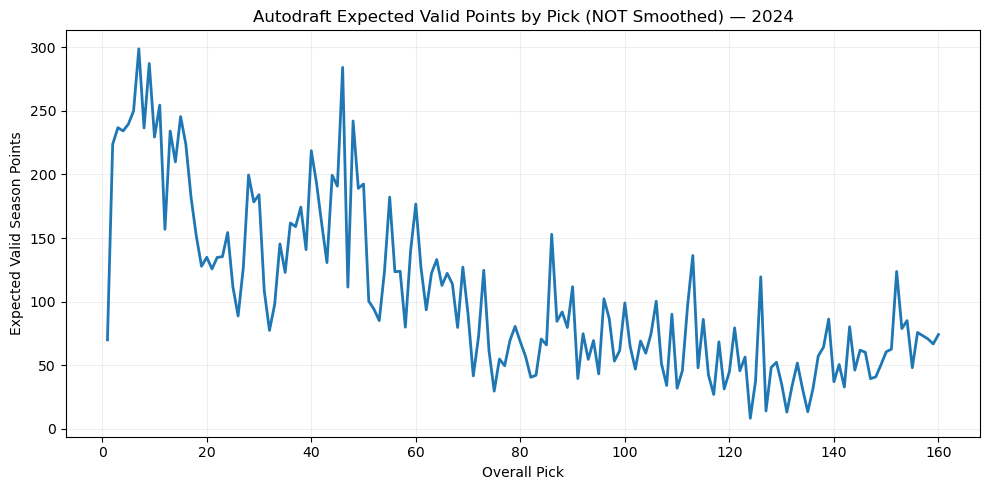

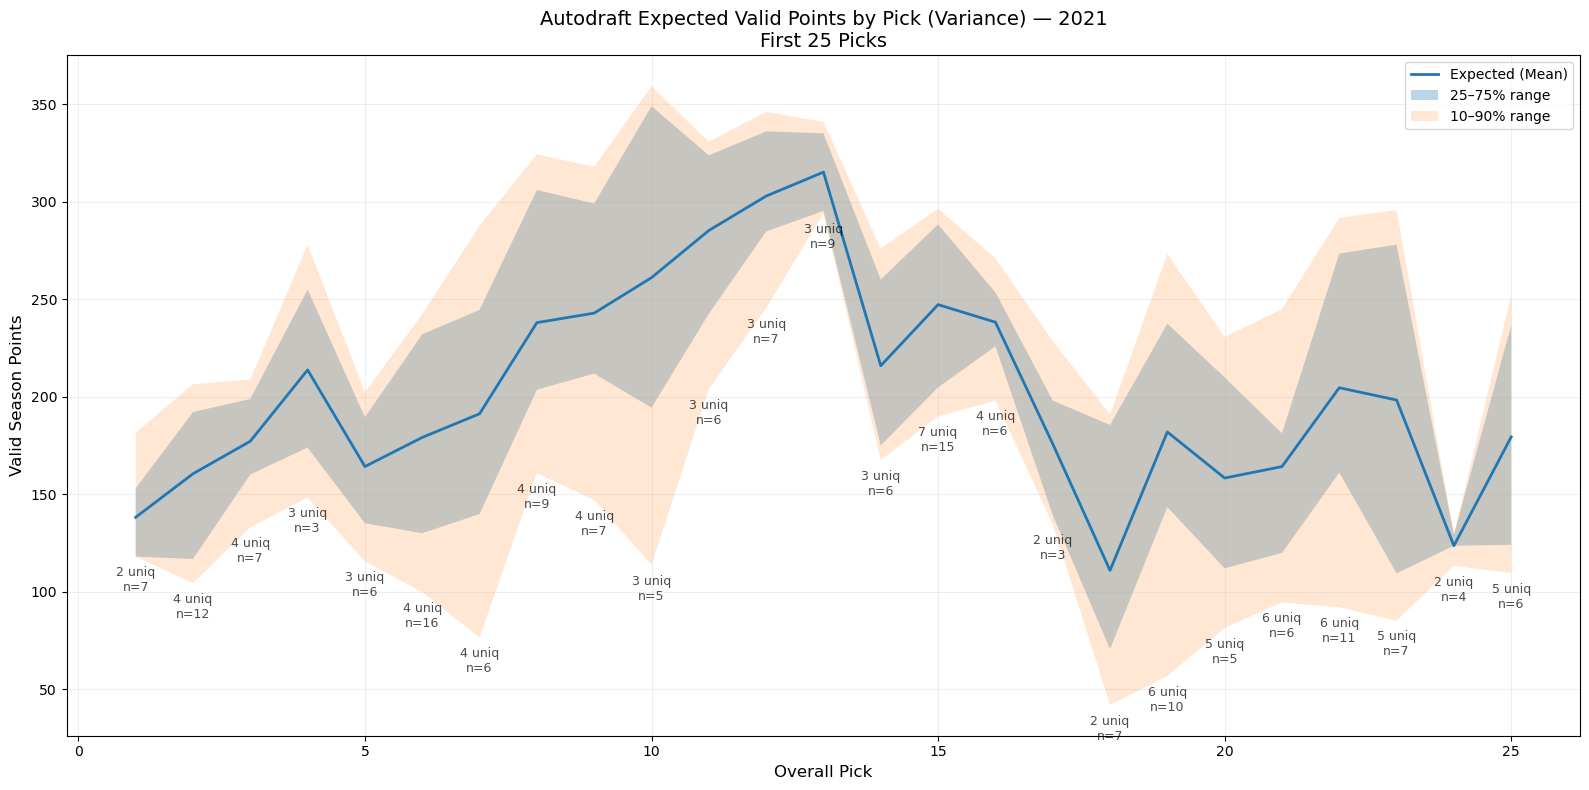

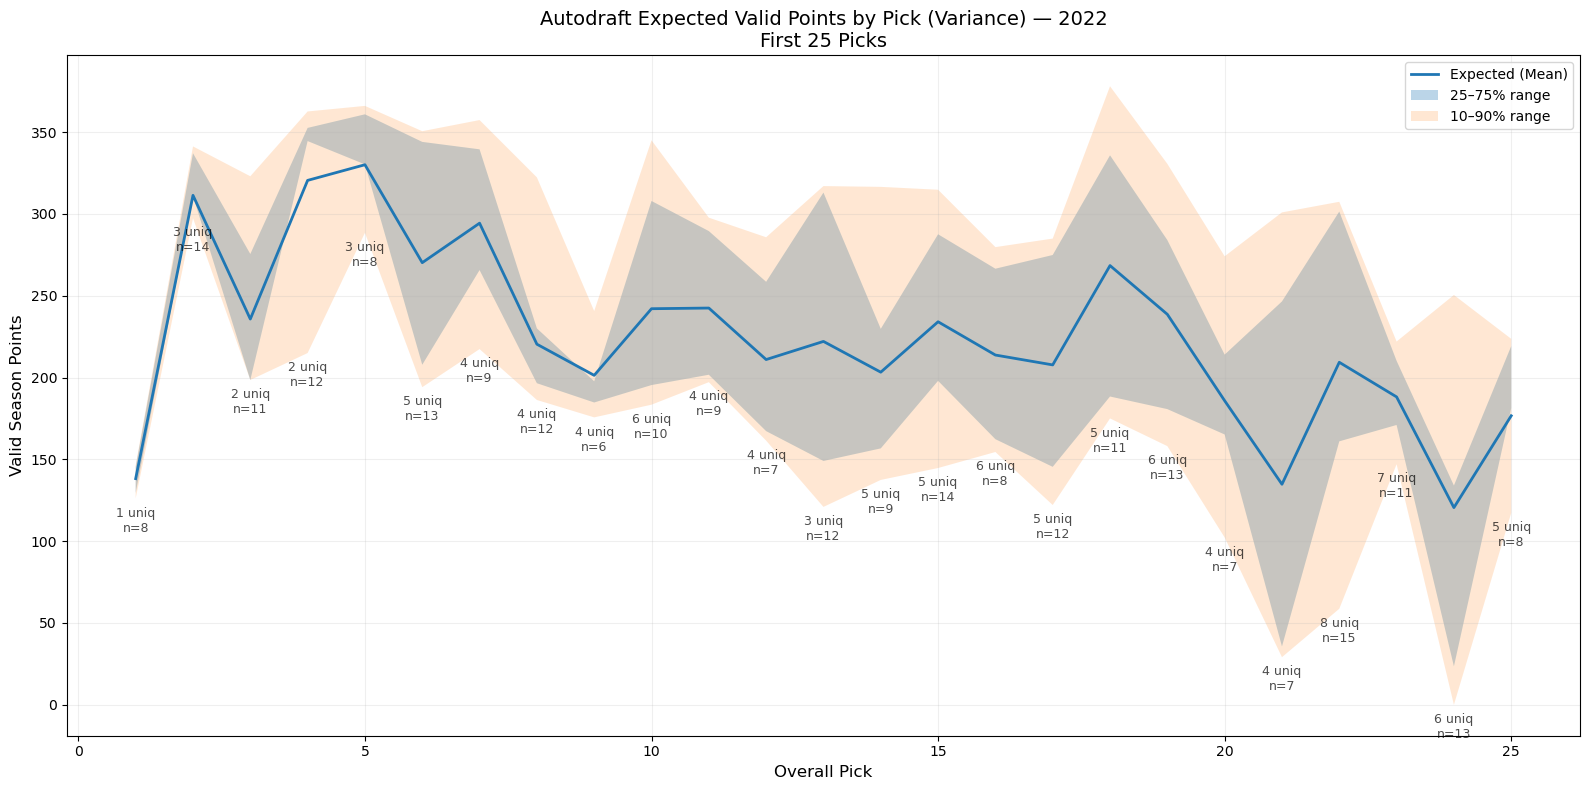

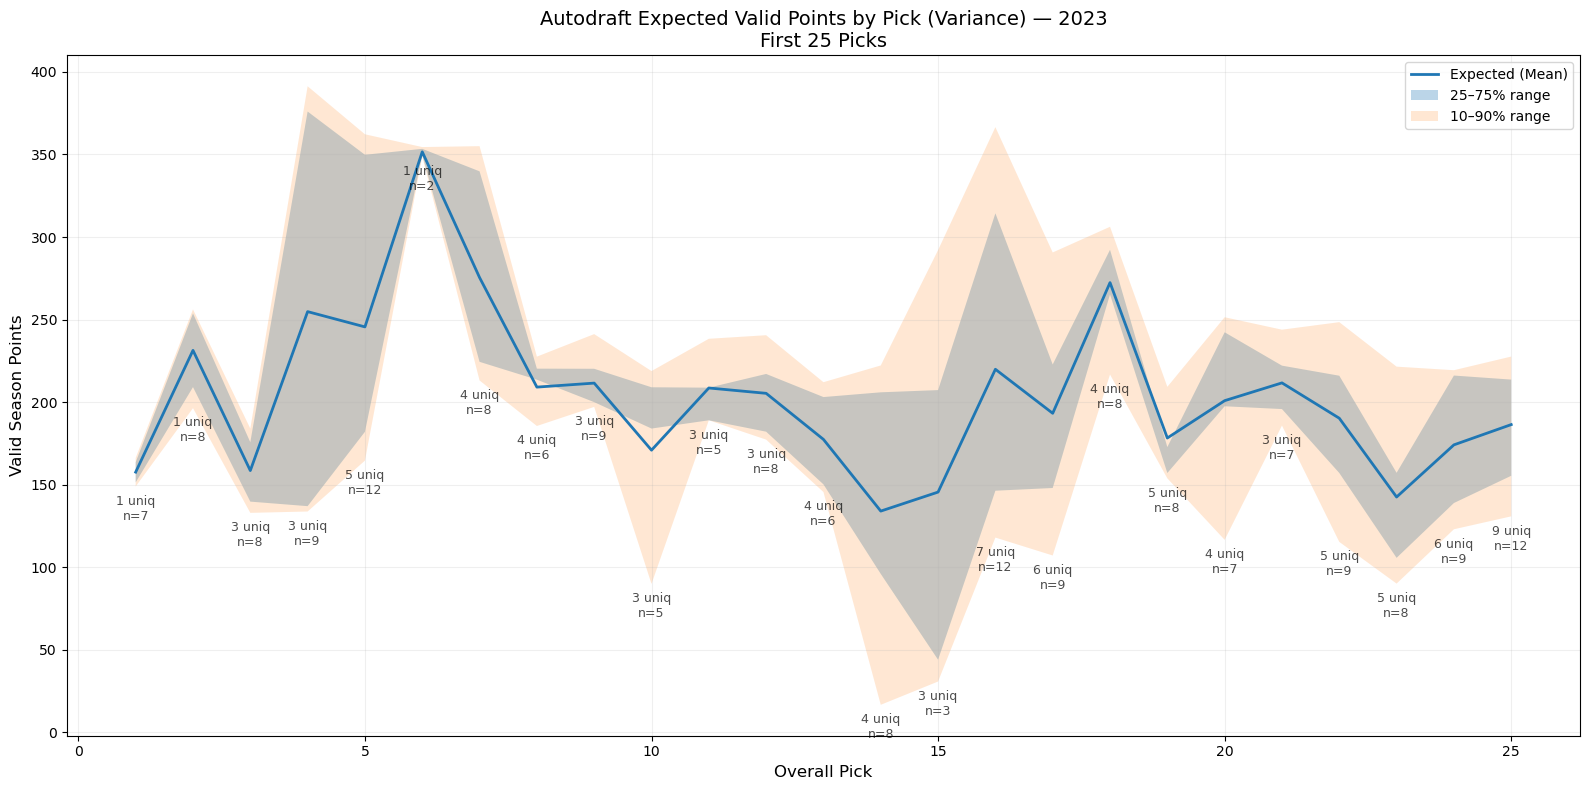

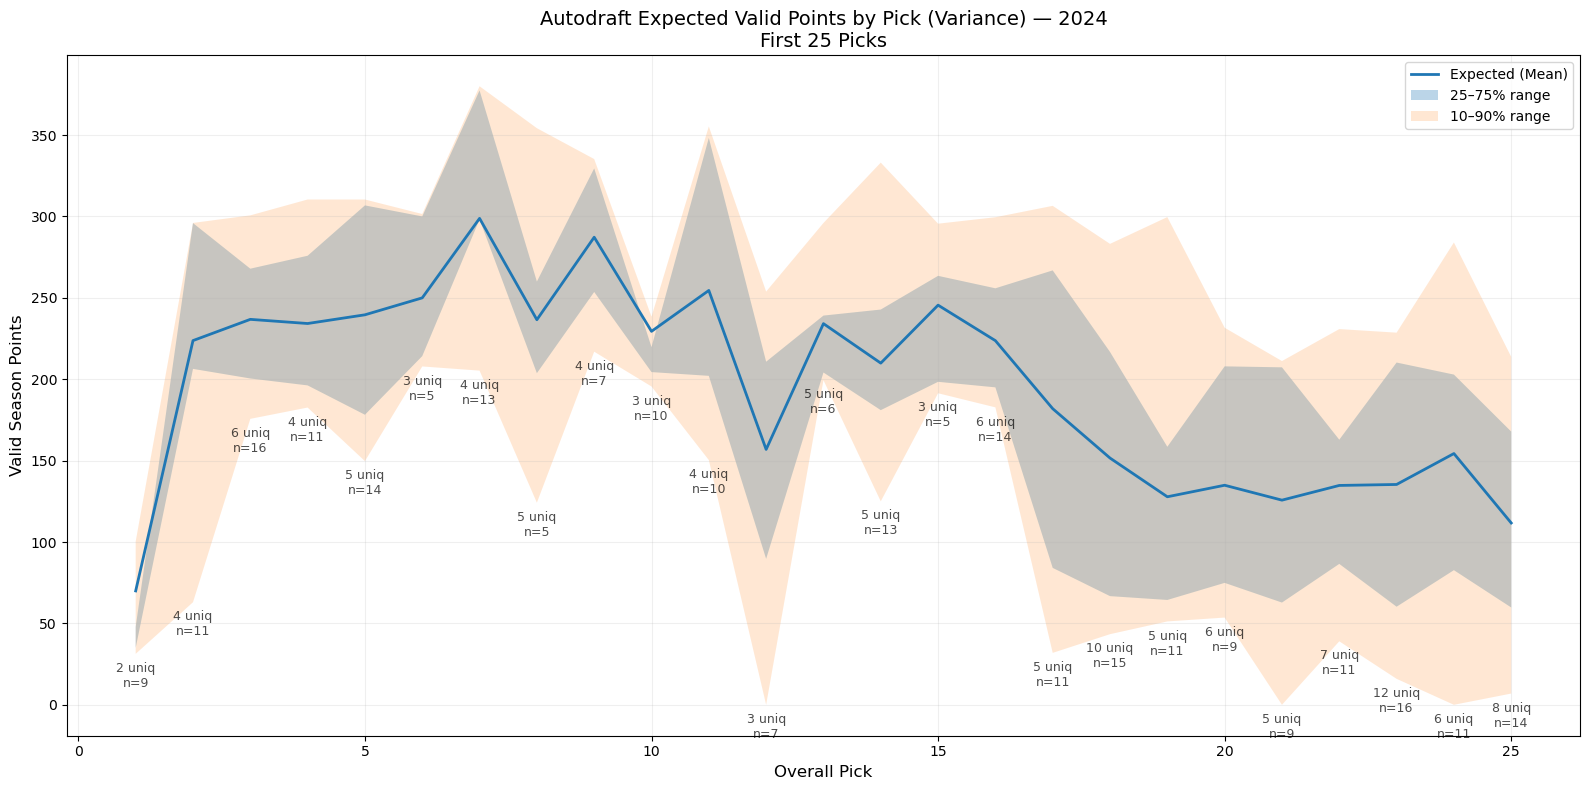

In [26]:
# ============================================================
# ADD-ON PLOTS — Per-season (NOT smoothed) + Per-season variance zoom (first 25)
# Assumes you already have:
#   - draft_with_valid (with Season_Total_Points_Valid, Player_norm, Overall, etc.)
#   - expected_valid_points_by_pick_from_autodraft(...)
#   - expected_valid_points_by_pick_autodraft_distribution(...)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ----------------------------
# Helper: compute dist BY YEAR
# ----------------------------
def expected_valid_points_by_pick_autodraft_distribution_by_year(
    draft_with_valid: pd.DataFrame
) -> pd.DataFrame:
    """
    Same as your pooled dist function, but returns one row per (Year, Overall)
    for fully-autodrafted teams only.

    Columns include: Mean, Std, N_Picks, Unique_Players, P10/P25/P50/P75/P90
    """
    required = [
        "League_ID","Year","Team",
        "Overall","Is_Autodrafted","Season_Total_Points_Valid","Player_norm"
    ]
    missing = [c for c in required if c not in draft_with_valid.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")

    df = draft_with_valid.copy()

    # fully-autodrafted teams (per league-year-team)
    team_auto = (
        df.groupby(["League_ID","Year","Team"], dropna=False)["Is_Autodrafted"]
          .agg(Total_Picks="size", Auto_Picks="sum")
          .reset_index()
    )
    team_auto["Is_Fully_Autodrafted"] = team_auto["Total_Picks"].eq(team_auto["Auto_Picks"])

    df = df.merge(
        team_auto[["League_ID","Year","Team","Is_Fully_Autodrafted"]],
        on=["League_ID","Year","Team"],
        how="left"
    )
    df = df[df["Is_Fully_Autodrafted"]].copy()

    # distribution by (Year, Overall)
    dist = (
        df.groupby(["Year","Overall"], dropna=False)
          .agg(
              Mean=("Season_Total_Points_Valid", "mean"),
              Std=("Season_Total_Points_Valid", "std"),
              N_Picks=("Season_Total_Points_Valid", "count"),
              Unique_Players=("Player_norm", "nunique"),
              P10=("Season_Total_Points_Valid", lambda s: s.quantile(0.10)),
              P25=("Season_Total_Points_Valid", lambda s: s.quantile(0.25)),
              P50=("Season_Total_Points_Valid", lambda s: s.quantile(0.50)),
              P75=("Season_Total_Points_Valid", lambda s: s.quantile(0.75)),
              P90=("Season_Total_Points_Valid", lambda s: s.quantile(0.90)),
          )
          .reset_index()
          .sort_values(["Year","Overall"])
    )

    return dist


# ============================================================
# 15D — Individual expected valid points by pick for each season (NOT smoothed)
# ============================================================

expected_by_pick_year = expected_valid_points_by_pick_from_autodraft(
    draft_with_valid,
    by_year=True
)

for year, g in expected_by_pick_year.groupby("Year", sort=True):
    plt.figure(figsize=(10, 5))
    plt.plot(g["Overall"], g["Expected_Valid_Points"], linewidth=2)
    plt.xlabel("Overall Pick")
    plt.ylabel("Expected Valid Season Points")
    plt.title(f"Autodraft Expected Valid Points by Pick (NOT Smoothed) — {int(year)}")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


# ============================================================
# 15E — First 25 pick variance chart PER SEASON (with N + Unique Players)
# ============================================================

dist_y = expected_valid_points_by_pick_autodraft_distribution_by_year(draft_with_valid)

for year, g in dist_y.groupby("Year", sort=True):
    g25 = g[g["Overall"] <= 25].copy()
    if g25.empty:
        continue

    fig, ax = plt.subplots(figsize=(16, 8))

    # mean line
    ax.plot(g25["Overall"], g25["Mean"], linewidth=2, label="Expected (Mean)")

    # IQR band
    ax.fill_between(g25["Overall"], g25["P25"], g25["P75"], alpha=0.30, label="25–75% range")

    # 10–90 band
    ax.fill_between(g25["Overall"], g25["P10"], g25["P90"], alpha=0.18, label="10–90% range")

    ax.set_xlabel("Overall Pick", fontsize=12)
    ax.set_ylabel("Valid Season Points", fontsize=12)
    ax.set_title(f"Autodraft Expected Valid Points by Pick (Variance) — {int(year)}\nFirst 25 Picks", fontsize=14)

    # annotate: Unique players + n picks
    for _, r in g25.iterrows():
        y_annot = (r["P10"] if pd.notna(r["P10"]) else r["Mean"]) - 5
        ax.text(
            r["Overall"],
            y_annot,
            f"{int(r['Unique_Players'])} uniq\nn={int(r['N_Picks'])}",
            ha="center",
            va="top",
            fontsize=9,
            alpha=0.7
        )

    ax.legend()
    ax.grid(alpha=0.2)
    fig.tight_layout()
    plt.show()


# ============================================================
# Optional: quick table sanity print for one year
# ============================================================
# print(dist_y[dist_y["Year"] == 2024].head(10).to_string(index=False))


In [ ]:
# Block 14 was here for some reason. 

In [27]:
# ============================================================
# BLOCK 16 — SCORE PICKS WITH MULTIPLE BASELINES
#   - Per-year mean baseline (Expected_Year)
#   - Pooled denoised baseline (Expected_Pooled_Denoised)
#   - Polynomial baseline fit to pooled denoised (Expected_Poly)
#
# Produces draft_scored with:
#   Points_Added_Year, Z_Year
#   Points_Added_Pooled, Z_Pooled
#   Points_Added_Poly, Z_Poly
#
# Assumes you already ran:
#   - expected_valid_points_by_pick_from_autodraft_pooled_denoised (Block 13)
#   - fit_polynomial_baseline (Block 14B)
#   - expected_valid_points_by_pick_from_autodraft (Block 14)
# ============================================================

import numpy as np
import pandas as pd

def score_picks_all_baselines(
    draft_with_valid: pd.DataFrame,
    *,
    estimator: str = "trimmed_mean",
    trim: float = 0.10,
    smooth_window: int = 5,
    poly_degree: int = 4,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      draft_scored,
      expected_by_pick_year,
      expected_by_pick_pooled_poly

    draft_scored gets points added + z-scores for:
      - per-year expected curve
      - pooled denoised curve
      - polynomial fit to pooled denoised
    """
    required = ["League_ID","Year","Team","Overall","Is_Autodrafted","Season_Total_Points_Valid"]
    missing = [c for c in required if c not in draft_with_valid.columns]
    if missing:
        raise ValueError(f"draft_with_valid missing columns: {missing}")

    df = draft_with_valid.copy()
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype(int)
    df["Overall"] = pd.to_numeric(df["Overall"], errors="coerce").astype(int)
    df["Is_Autodrafted"] = pd.to_numeric(df["Is_Autodrafted"], errors="coerce").fillna(0).astype(int)
    df["Season_Total_Points_Valid"] = pd.to_numeric(df["Season_Total_Points_Valid"], errors="coerce")

    # -------------------------
    # (A) Per-year baseline
    # -------------------------
    expected_by_pick_year = expected_valid_points_by_pick_from_autodraft(df, by_year=True).copy()
    expected_by_pick_year = expected_by_pick_year.rename(columns={
        "Expected_Valid_Points": "Expected_Year",
        "Std_Valid_Points": "Std_Year",
        "N": "N_Year",
    })

    draft_scored = df.merge(
        expected_by_pick_year[["Year","Overall","Expected_Year","Std_Year","N_Year"]],
        on=["Year","Overall"],
        how="left",
    )

    draft_scored["Points_Added_Year"] = draft_scored["Season_Total_Points_Valid"] - draft_scored["Expected_Year"]
    draft_scored["Z_Year"] = np.where(
        (draft_scored["Std_Year"].notna()) & (draft_scored["Std_Year"] > 0),
        draft_scored["Points_Added_Year"] / draft_scored["Std_Year"],
        np.nan
    )

    # -------------------------
    # (B) Pooled denoised + Poly
    # -------------------------
    expected_by_pick_pooled = expected_valid_points_by_pick_from_autodraft_pooled_denoised(
        df,
        estimator=estimator,
        trim=trim,
        smooth_window=smooth_window
    ).copy()

    # Fit polynomial to pooled denoised curve
    expected_by_pick_pooled_poly = fit_polynomial_baseline(
        expected_by_pick_pooled,
        y_col="Expected_Smoothed",
        w_col="N",
        degree=poly_degree
    ).copy()

    expected_by_pick_pooled_poly = expected_by_pick_pooled_poly.rename(columns={
        "Expected_Smoothed": "Expected_Pooled_Denoised",
        "Std_Valid_Points": "Std_Pooled",
        "N": "N_Pooled",
        "Poly_Expected": "Expected_Poly",
    })

    # Merge pooled baselines (one curve) by Overall only
    draft_scored = draft_scored.merge(
        expected_by_pick_pooled_poly[["Overall","Expected_Pooled_Denoised","Expected_Poly","Std_Pooled","N_Pooled"]],
        on="Overall",
        how="left",
    )

    # Points added for pooled denoised
    draft_scored["Points_Added_Pooled"] = (
        draft_scored["Season_Total_Points_Valid"] - draft_scored["Expected_Pooled_Denoised"]
    )
    draft_scored["Z_Pooled"] = np.where(
        (draft_scored["Std_Pooled"].notna()) & (draft_scored["Std_Pooled"] > 0),
        draft_scored["Points_Added_Pooled"] / draft_scored["Std_Pooled"],
        np.nan
    )

    # Points added for polynomial baseline
    draft_scored["Points_Added_Poly"] = (
        draft_scored["Season_Total_Points_Valid"] - draft_scored["Expected_Poly"]
    )
    # Reuse pooled std as scale for z (your prior choice)
    draft_scored["Z_Poly"] = np.where(
        (draft_scored["Std_Pooled"].notna()) & (draft_scored["Std_Pooled"] > 0),
        draft_scored["Points_Added_Poly"] / draft_scored["Std_Pooled"],
        np.nan
    )

    return draft_scored, expected_by_pick_year, expected_by_pick_pooled_poly


# ---- RUN ----
draft_scored, expected_by_pick_year, expected_by_pick_pooled_poly = score_picks_all_baselines(
    draft_with_valid,
    estimator="trimmed_mean",
    trim=0.10,
    smooth_window=5,
    poly_degree=4
)

# Optional quick peek
draft_scored[[
    "League_ID","Year","Team","Overall","Player_norm",
    "Season_Total_Points_Valid",
    "Expected_Year","Expected_Pooled_Denoised","Expected_Poly",
    "Points_Added_Year","Points_Added_Pooled","Points_Added_Poly",
    "Z_Year","Z_Pooled","Z_Poly"
]].head()


,League_ID,Year,Team,Overall,Player_norm,Season_Total_Points_Valid,Expected_Year,Expected_Pooled_Denoised,Expected_Poly,Points_Added_Year,Points_Added_Pooled,Points_Added_Poly,Z_Year,Z_Pooled,Z_Poly
0,1409356,2021,1,1,Patrick Mahomes,335.46,138.157143,191.230448,245.478784,197.302857,144.229552,89.981216,6.486438,2.391125,1.491763
1,1409356,2021,14,2,Christian McCaffrey,118.00,160.476667,210.668526,241.831809,-42.476667,-92.668526,-123.831809,-0.566831,-1.051543,-1.405164
2,1409356,2021,12,3,Dalvin Cook,179.60,177.171429,218.078446,238.252427,2.428571,-38.478446,-58.652427,0.071997,-0.591235,-0.901215
3,1409356,2021,4,4,Derrick Henry,193.30,213.733333,240.280446,234.738932,-20.433333,-46.980446,-41.438932,-0.251998,-0.520951,-0.459503
4,1409356,2021,2,5,Alvin Kamara,209.50,164.183333,248.978428,231.289649,45.316667,-39.478428,-21.789649,1.120875,-0.460713,-0.254285


# This needs sanity checking

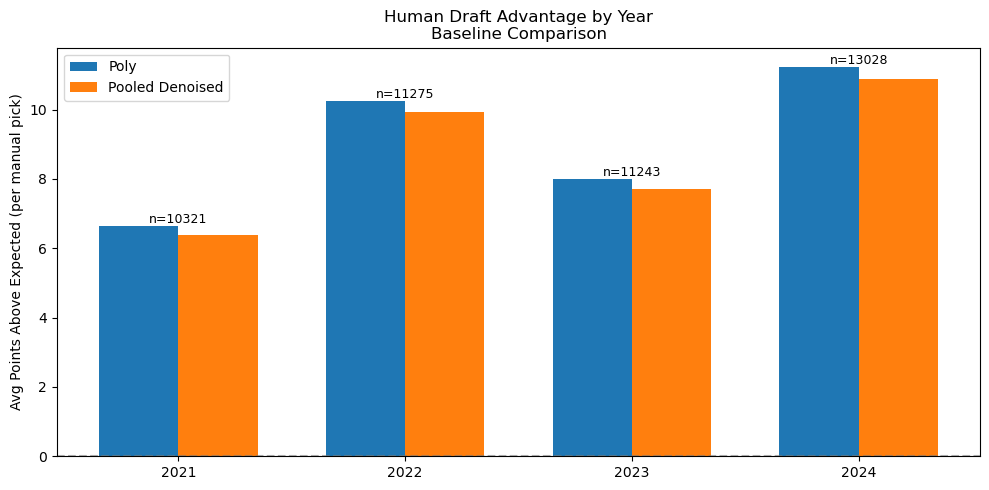

,Year,Manual_Picks,Avg_Points_Added_Poly,Avg_Points_Added_Pooled
0,2021,10321,6.639046,6.381898
1,2022,11275,10.257537,9.920004
2,2023,11243,8.001592,7.698506
3,2024,13028,11.221574,10.889311


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Guardrails: ensure Block 16 outputs exist ---
required_cols = {
    "Year", "Is_Autodrafted",
    "Points_Added_Poly", "Points_Added_Pooled"
}
missing = required_cols - set(draft_scored.columns)
if missing:
    raise ValueError(f"draft_scored missing required columns for Block 17+: {sorted(missing)}")

# Manual picks only
manual = draft_scored[draft_scored["Is_Autodrafted"] == 0].copy()

summary_year = (
    manual
    .groupby("Year", dropna=False)
    .agg(
        Manual_Picks=("Points_Added_Poly", "size"),
        Avg_Points_Added_Poly=("Points_Added_Poly", "mean"),
        Avg_Points_Added_Pooled=("Points_Added_Pooled", "mean"),
    )
    .reset_index()
    .sort_values("Year")
)

# Side-by-side bars
x = np.arange(len(summary_year))
w = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - w/2, summary_year["Avg_Points_Added_Poly"], width=w, label="Poly")
plt.bar(x + w/2, summary_year["Avg_Points_Added_Pooled"], width=w, label="Pooled Denoised")

plt.axhline(0, linestyle="--", color="gray", alpha=0.6)
plt.xticks(x, summary_year["Year"])
plt.ylabel("Avg Points Above Expected (per manual pick)")
plt.title("Human Draft Advantage by Year\nBaseline Comparison")

# annotate n
for i, r in summary_year.iterrows():
    y_top = max(r["Avg_Points_Added_Poly"], r["Avg_Points_Added_Pooled"])
    plt.text(i, y_top, f"n={int(r['Manual_Picks'])}", ha="center", va="bottom", fontsize=9)

plt.legend()
plt.tight_layout()
plt.show()

summary_year


# THIS ONE NEEDS DOUBLE CHECKING

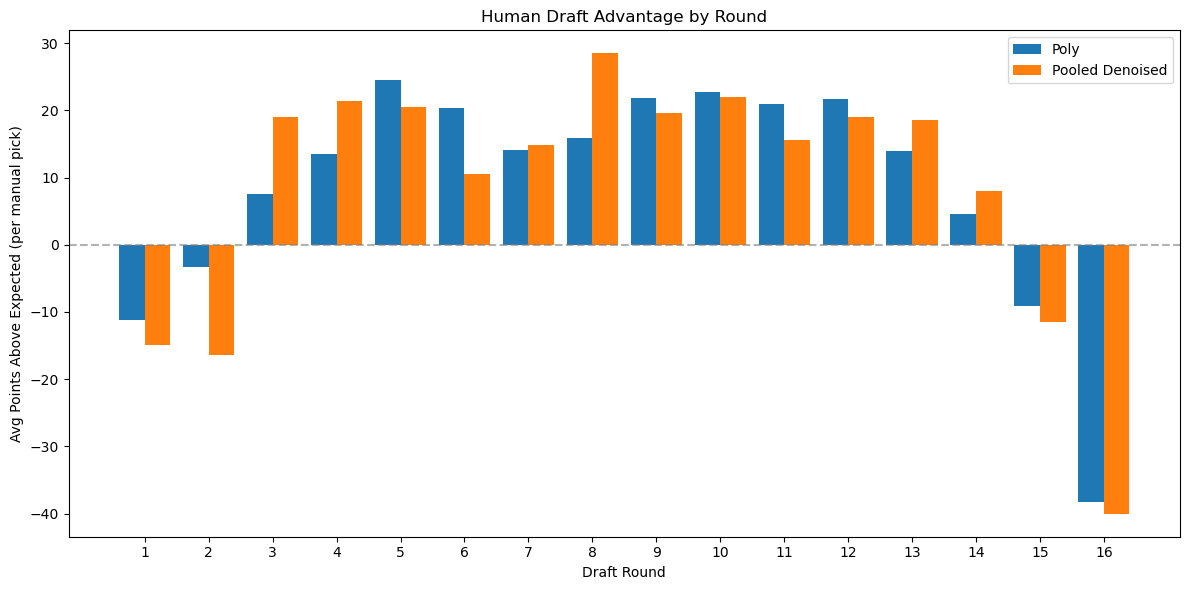

,Round,Manual_Picks,Avg_Poly,Avg_Pooled
0,1,2925,-11.119411,-14.845998
1,2,2947,-3.334492,-16.448632
2,3,2947,7.633178,19.039162
3,4,2959,13.503280,21.376643
4,5,2955,24.587663,20.521602
5,6,2952,20.381742,10.543047
6,7,2953,14.038472,14.864623
7,8,2934,15.912616,28.494770
8,9,2922,21.806306,19.621056
9,10,2893,22.704924,22.013928


In [50]:
# ============================================================
# BLOCK 17B — Avg Points Above Expected by ROUND (Manual picks)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# Guardrails
required_cols_round = {"Round", "Points_Added_Poly", "Points_Added_Pooled"}
missing = required_cols_round - set(manual.columns)
if missing:
    raise ValueError(f"manual missing required columns for Block 17B: {sorted(missing)}")

summary_round = (
    manual
    .groupby("Round", dropna=False)
    .agg(
        Manual_Picks=("Points_Added_Poly", "size"),
        Avg_Poly=("Points_Added_Poly", "mean"),
        Avg_Pooled=("Points_Added_Pooled", "mean"),
    )
    .reset_index()
)

# ensure numeric sort
summary_round["Round"] = pd.to_numeric(summary_round["Round"], errors="coerce")
summary_round = summary_round.sort_values("Round")

x = np.arange(len(summary_round))
w = 0.4

plt.figure(figsize=(12,6))
plt.bar(x - w/2, summary_round["Avg_Poly"], width=w, label="Poly")
plt.bar(x + w/2, summary_round["Avg_Pooled"], width=w, label="Pooled Denoised")

plt.axhline(0, linestyle="--", color="gray", alpha=0.6)
plt.xticks(x, summary_round["Round"])
plt.xlabel("Draft Round")
plt.ylabel("Avg Points Above Expected (per manual pick)")
plt.title("Human Draft Advantage by Round")
plt.legend()
plt.tight_layout()
plt.show()

summary_round


# This one needs double checking too 

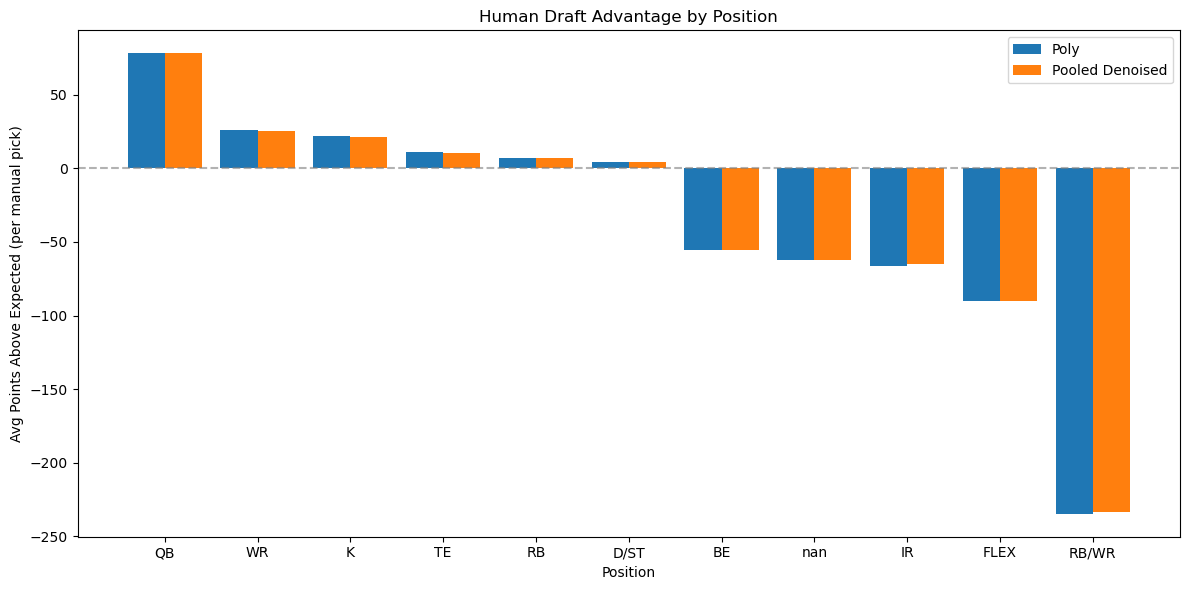

,Position,Manual_Picks,Avg_Poly,Avg_Pooled
5,QB,4531,78.235909,78.268903
9,WR,12196,26.349053,25.762934
4,K,2893,21.853161,21.590074
8,TE,4329,10.996278,10.431973
6,RB,10864,7.323316,6.896118
1,D/ST,3081,4.349691,4.214459
0,BE,6949,-55.511825,-55.391157
10,NaN,501,-62.310339,-62.419282
3,IR,211,-66.198632,-64.963307
2,FLEX,310,-89.959467,-89.903318


In [51]:
# ============================================================
# BLOCK 17C — Human Advantage by POSITION
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# Guardrails
required_cols_pos = {"Position", "Points_Added_Poly", "Points_Added_Pooled"}
missing = required_cols_pos - set(manual.columns)
if missing:
    raise ValueError(f"manual missing required columns for Block 17C: {sorted(missing)}")

summary_pos = (
    manual
    .groupby("Position", dropna=False)
    .agg(
        Manual_Picks=("Points_Added_Poly", "size"),
        Avg_Poly=("Points_Added_Poly", "mean"),
        Avg_Pooled=("Points_Added_Pooled", "mean"),
    )
    .reset_index()
)

# Sort by one baseline for readability (pick whichever you prefer)
summary_pos = summary_pos.sort_values("Avg_Poly", ascending=False)

x = np.arange(len(summary_pos))
w = 0.4

plt.figure(figsize=(12,6))
plt.bar(x - w/2, summary_pos["Avg_Poly"], width=w, label="Poly")
plt.bar(x + w/2, summary_pos["Avg_Pooled"], width=w, label="Pooled Denoised")

plt.axhline(0, linestyle="--", color="gray", alpha=0.6)
plt.xticks(x, summary_pos["Position"])
plt.xlabel("Position")
plt.ylabel("Avg Points Above Expected (per manual pick)")
plt.title("Human Draft Advantage by Position")
plt.legend()
plt.tight_layout()
plt.show()

summary_pos

